# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Загрузим все необходимые библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# для расчета MSE и RMSE
from sklearn.metrics import mean_squared_error
# для масштабирования количественных признаков
from sklearn.preprocessing import StandardScaler
# для поиска оптимальных параметров
from sklearn.model_selection import GridSearchCV
# Добавим функцию перемешивания.
from sklearn.utils import shuffle
# для доверительного интервала
from scipy import stats as st
# Чтобы предупреждение не появлялось, в код добавляют строчку.
pd.options.mode.chained_assignment = None

# задаем рандомстейт.
RANDOM_STATE = 12345

In [2]:
# загрузим файлы в проект.
region_0 = pd.read_csv('geo_data_0.csv')
region_1 = pd.read_csv('geo_data_1.csv')
region_2 = pd.read_csv('geo_data_2.csv')


In [3]:
# загрузим функцию информации о датафрейме.
%run "C:\Users\Windows-10\work\small_review.py"

In [4]:
# Посмотрим данные.
print('Регион 0')
review(region_0)
print('Регион 1')
review(region_1)
print('Регион 2')
review(region_2)


Регион 0


id        f0        f1        f2     product
53594  T5aXl -0.449454  0.959132  3.036759  131.895647
5096   5qRzY  0.874623 -0.421494  2.982857  135.210114
4528   fcY8R  1.024308 -0.110729  6.757734  152.374851
66743  89DAB -0.409406  0.768818  6.210276  114.217260
60341  J1Aqc  1.753713  0.002096  5.801049  149.061958

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

'Корреляция признаков:'

f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000

Количество явных дубликатов: 0
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Регион 1


id         f0        f1        f2     product
37939  KsaRi   3.410080 -8.270047  3.990971  107.813044
31065  9EmrN  11.355285 -6.949261  2.995079   80.859783
57521  vuv14   0.891097 -5.374050  1.002994   30.132364
88255  Agl4b   3.305848 -1.003427  1.995089   53.906522
19325  5OuEM  13.018830 -3.904199  1.003172   26.953261

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

'Корреляция признаков:'

f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000

Количество явных дубликатов: 0
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Регион 2


id        f0        f1        f2     product
60225  hIudB  0.361595 -0.366474  4.229644   83.008761
30146  Z9SUk  1.049630  0.126041  8.266295  113.155323
99458  oMid3  0.676806 -2.452626  7.303980  161.873776
51164  cXwJH -1.058123  1.353435  3.043455   24.502004
22342  9n0pF  2.853648  0.581511  4.758459  141.349160

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

'Корреляция признаков:'

f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000

Количество явных дубликатов: 0
Количество пропусков: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [5]:
# корреляция на графике региона_0.
plt.rcParams['figure.figsize'] = (10.0, 10.0)
sns.heatmap(region_0.corr(numeric_only=True), annot=True, linewidths=3, linecolor='white')


<Axes: >

<Axes: >

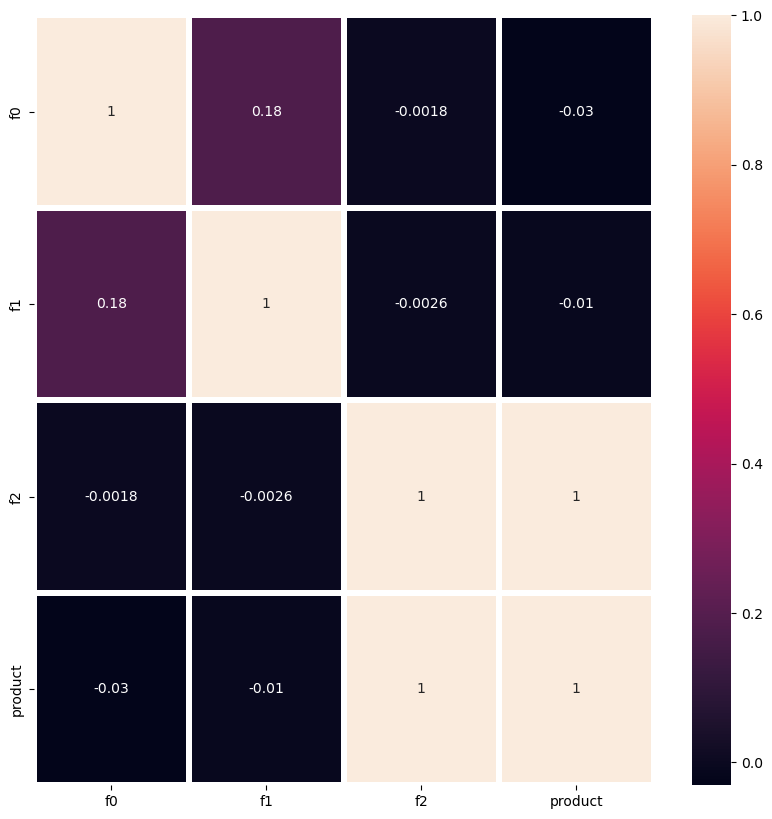

In [6]:
# корреляция для региона_1.
sns.heatmap(region_1.corr(numeric_only=True), annot=True, linewidths=3, linecolor='white')

In [7]:
# корреляция для регион_2.
sns.heatmap(region_2.corr(numeric_only=True), annot=True, linewidths=3, linecolor='white')


<Axes: >

In [8]:
# мы будем использовать эти данные для прогнозирования, столбцы с id нам не нужны, удалим их из датасетов.
region_0 = region_0.drop('id', axis=1)
region_1 = region_1.drop('id', axis=1)
region_2 = region_2.drop('id', axis=1)
print(region_0.columns.values.tolist())
print(region_1.columns.values.tolist())
print(region_2.columns.values.tolist())


['f0', 'f1', 'f2', 'product']
['f0', 'f1', 'f2', 'product']
['f0', 'f1', 'f2', 'product']


### Вывод
Представленные данные сложно проанализировать, т.к. значение показателей не известны, кроме столбца product -- объем залежей нефти.

Пропусков и дубликатов в данных не обнаружено. Корреляции признаков нет. Средние значения во всех датасетах близки к медианным.

Необходимости в обработке нет.

Перед созданием модели, потребуется провести масштабирование значений.


## Обучение и проверка модели

Подготовим данные, выделим признаки и целевой признак, разделим на обучающую и валидационную выборки в соотношении 75:25, отмасштабируем.


In [9]:
# мы работаем с тремя регионами, напишем функцию деления данных.
def data_division(geo_data_region):
    features = geo_data_region.drop('product', axis=1)
    target = geo_data_region['product']
    # разделим выборки в пропорции 75:25.
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
    # проведем масштабирование
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid, target_train, target_valid


In [10]:
# получим features и target для регионов.
features_train_0, features_valid_0, target_train_0, target_valid_0 = data_division(region_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = data_division(region_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = data_division(region_2)


In [11]:
# проверим работу функции.
print(f'Регион_0: {features_train_0.shape}, {features_valid_0.shape}, {target_train_0.shape}, {target_valid_0.shape}')

print(f'Регион_1: {features_train_1.shape}, {features_valid_1.shape}, {target_train_1.shape}, {target_valid_1.shape}')

print(f'Регион_2: {features_train_2.shape}, {features_valid_2.shape}, {target_train_2.shape}, {target_valid_2.shape}')


Регион_0: (75000, 3), (25000, 3), (75000,), (25000,)
Регион_1: (75000, 3), (25000, 3), (75000,), (25000,)
Регион_2: (75000, 3), (25000, 3), (75000,), (25000,)


In [12]:
# проверим как прошло масштабирование
display(features_train_0.describe())

display(features_train_1.describe())

display(features_train_2.describe())


f0            f1            f2
count  7.500000e+04  7.500000e+04  7.500000e+04
mean   1.680907e-16 -3.474554e-17  6.442254e-18
std    1.000007e+00  1.000007e+00  1.000007e+00
min   -2.186288e+00 -2.178269e+00 -3.890945e+00
25%   -6.575544e-01 -8.925344e-01 -6.799576e-01
50%    1.878842e-03 -7.407961e-04  4.288679e-03
75%    6.571176e-01  8.928514e-01  6.829752e-01
max    2.139081e+00  2.169192e+00  4.153623e+00

f0            f1            f2
count  7.500000e+04  7.500000e+04  7.500000e+04
mean  -1.136868e-18 -2.717115e-16 -2.030968e-17
std    1.000007e+00  1.000007e+00  1.000007e+00
min   -3.652789e+00 -4.206546e+00 -1.476535e+00
25%   -8.290577e-01 -6.766541e-01 -8.784844e-01
50%    1.734177e-03 -1.083306e-03 -2.838957e-01
75%    8.349682e-01  6.768381e-01  8.834721e-01
max    3.154487e+00  4.588691e+00  1.482457e+00

f0            f1            f2
count  7.500000e+04  7.500000e+04  7.500000e+04
mean  -2.122154e-17  7.294905e-18 -8.251770e-17
std    1.000007e+00  1.000007e+00  1.000007e+00
min   -5.060306e+00 -4.088636e+00 -4.167323e+00
25%   -6.716773e-01 -6.783003e-01 -6.785573e-01
50%    3.845213e-03 -5.219873e-03 -5.092214e-03
75%    6.656278e-01  6.749474e-01  6.802621e-01
max    4.176529e+00  4.533914e+00  4.101780e+00

In [13]:
# обучим модель регрессии случайного леса, получим предсказания, средний запас предсказанного сырья и RMSE модели.
def modeling(features_train, features_valid, target_train, target_valid):
    # инициализируем модель
    model = RandomForestRegressor(n_estimators=150, max_depth=50, verbose=1, random_state=RANDOM_STATE)
    # обучаем модель на тренировочной выборке
    model.fit(features_train, target_train)
    # получаем предсказания модели на валидационной выборке
    predictions_valid = pd.Series(model.predict(features_valid))
    # считаем значение метрики RMSE на валидационной выборке
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    # среднее значение предсказанного сырья
    mean_pred_pr = predictions_valid.mean()
    
    return predictions_valid, rmse, mean_pred_pr


In [14]:
# получим данные для всех регионов
predictions_valid_0, rmse_0, mean_pred_pr_0 = modeling(features_train_0, features_valid_0, target_train_0, target_valid_0)
predictions_valid_1, rmse_1, mean_pred_pr_1 = modeling(features_train_1, features_valid_1, target_train_1, target_valid_1)
predictions_valid_2, rmse_2, mean_pred_pr_2 = modeling(features_train_2, features_valid_2, target_train_2, target_valid_2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   47.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished


In [15]:
# для оценки правильности работы модели покажем предсказанный и истинный запас сырья.
print(f'Для региона 0, предсказанный моделью средний запас сырья равен: {mean_pred_pr_0}, RMSE модели: {rmse_0}')
print(f'Для региона 0, истинный средний запас сырья равен: {target_valid_0.mean()}')
print(f'Для региона 1, предсказанный моделью средний запас сырья равен: {mean_pred_pr_1}, RMSE модели: {rmse_1}')
print(f'Для региона 1, истинный средний запас сырья равен: {target_valid_1.mean()}')
print(f'Для региона 2, предсказанный моделью средний запас сырья равен: {mean_pred_pr_2}, RMSE модели: {rmse_2}')
print(f'Для региона 2, истинный средний запас сырья равен: {target_valid_2.mean()}')


Для региона 0, предсказанный моделью средний запас сырья равен: 92.58119935467282, RMSE модели: 38.74016680597494
Для региона 0, истинный средний запас сырья равен: 92.07859674082927
Для региона 1, предсказанный моделью средний запас сырья равен: 68.732129917508, RMSE модели: 0.7595843402566775
Для региона 1, истинный средний запас сырья равен: 68.72313602435997
Для региона 2, предсказанный моделью средний запас сырья равен: 95.05628242751543, RMSE модели: 39.31573463003638
Для региона 2, истинный средний запас сырья равен: 94.88423280885438


### Вывод
По результату работы данного этапа можно сказать следующие:

* Все 3 модели предсказывают близкие к истинным значения. Средние запасы отличаются от предсказанных всего на несколько сотых.
* Наилучшими прогнозными свойствами обладает модель региона 1.
* Предсказательные способности моделей для 0 и 2 регионов примерно одинаковые (согласно параметрам RMSE).


## Подготовка к расчёту прибыли

Ввод ключевых переменных.


In [16]:
# количество точек для исследования
explore_count = 500

# количество точек для разработки
points_of_wells = 200

# бюджет на разработку скважин в регионе.
budget = 10_000_000_000

# один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
price_one_thous_and_barrels = 450_000

# максимальная вероятность убытков
maximum_loss_probability = 0.025

bootstrap_samples = 1000

Для расчета достаточного объема сырья для безубыточной разработки новой скважины необходимо:

* Вычислить допустимые средние затраты на разработку одной скважины - разделить бюджет на количество скважин.
* Вычислить какое количество в баррелях необходимо для покрытия затрат на одну скважину.


In [17]:
# затраты на разработку одной скважины
budget_per_borehole = budget / points_of_wells
print(f'Затраты на разработка одной скважины составляют {budget_per_borehole} рублей')

# необходимый объем сырья для безубыточной разработки 1 скважины  баррелей
sufficient_product_volume = budget_per_borehole / price_one_thous_and_barrels
print(f'Необходимый объем сырья для безубыточной разработки одной скважины составляет {sufficient_product_volume}')

Затраты на разработка одной скважины составляют 50000000.0 рублей
Необходимый объем сырья для безубыточной разработки одной скважины составляет 111.11111111111111


### Вывод
Необходимый объем нефти для того, чтобы разработка скважины была окупаемой составил 111 тыс. баррелей.

Средние значения запасов сырья для всех трех регионов ниже необходимого объема, это говорит о том, что при осуществлении разработки скважин, выбранных случайным образом, имеется высокая доля риска не окупить затраченный бюджет.

Важно иметь модель, которая наиболее корректно предсказывала бы объем продукта в зависимости от известных факторов.

На следующем этапе проверим работоспособность созданных ранее моделей для определения скважин с максимальными значениями предсказаний.


## Расчёт прибыли и рисков 

 Произведем выбор скважин с максимальными значениями предсказаний. По условиям задачи для разработки берутся 200 лучших скважин, найдем для них соответствующие истинные значения и по ним проведем расчет прибыли. Добавим функцию, чтобы не дублировать код для каждого региона.

In [18]:
def income_calc(target_valid, predictions_valid):
    # выбираем 200 скважин с максимальным объемом нефти
    pred_choice = predictions_valid.sort_values(ascending=False).head(200)
    # определяем верные значения для отобранных 200 скважин
    target_choice = target_valid.reset_index(drop=True)[pred_choice.index]
    # доход в млн. рублей с 200 скважин
    income = target_choice.sum() * price_one_thous_and_barrels
    return income


In [19]:
print('Прибыль из выбранных по предсказанию модели 200 скважин составляет:')
print(f'Для региона 0 - {income_calc(target_valid_0, predictions_valid_0) - budget} руб.')
print(f'Для региона 1 - {income_calc(target_valid_1, predictions_valid_1) - budget} руб.')
print(f'Для региона 2 - {income_calc(target_valid_2, predictions_valid_2) - budget} руб.')


Прибыль из выбранных по предсказанию модели 200 скважин составляет:
Для региона 0 - 2935387551.5624714 руб.
Для региона 1 - 2415086696.681511 руб.
Для региона 2 - 3219283682.988781 руб.


Значения прибыли для каждого региона - от 2.4 до 3.3 млрд руб.

Данные показатели можно получить, при проведении геологоразведки по 25000 точкам, а это повлечет несоизмеримые с вложениями затраты.

Согласно требованиям заказчика мы можем провести геологоразведку только по 500 точкам.

Далее проанализируем изменение прибыли в каждом регионе.

In [20]:
# изменим формулу расчета выручки для варианта, когда задается количество скважин, по которым производится поиск наибольших значений нефти.
def revenue(target_valid, predictions_valid, points_of_wells):
    # сортируем скважины по значениям их предсказаний
    pred_choice = predictions_valid.sort_values(ascending=False)
    
    # определяем верные значения для отобранных случайных скважин и берем только нужное количество
    target_choice = target_valid[pred_choice.index][:points_of_wells]
    # доход рублей
    income = target_choice.sum() * price_one_thous_and_barrels
    return income

In [21]:
# создадим функцию для применения для каждого региона
def income_distribution(predictions_valid, target_valid, bootstrap_samples, explore_count):
    state = np.random.RandomState(RANDOM_STATE)
    # с помощью этого счетчика будем считать вероятность убытков в регионе
    count = 0
    # здесь будут все значения выручек для 1000 выборок
    values = []

    # создаем 1000 выборок
    for i in range(bootstrap_samples):
        # у целевого признака валидацонной выборки сбрасываем индексы и случайно выбираем нужное количество скважин
        target_subsample = target_valid.reset_index(drop=True).sample(explore_count, replace=True, random_state=state)
        
        # из предсказаний выбираем строки соответствующие отобранным строкам в целевом признаке
        probs_subsample = predictions_valid[target_subsample.index]
        
        # считаем выручку для отобранных строк, но только для нужного количества скважин
        rev = revenue(target_subsample, probs_subsample, points_of_wells) - budget
        # добавляем выручку в список выручек всех выборок
        values.append(rev)
        
        # проверяем не является выборка убыточной, если является, то увеличиваем счетчик
        if rev < 0:
            count +=1

    values = pd.Series(values)

    # посчитаем и выведем среднюю выручку, убыток, максимальную прибыль
    mean = values.mean()
    loss = values[values < 0]
    print(f'Средняя прибыль: {mean} рублей, максимальная прибыль {values.max()}, а убыток {loss.min()}')

    # посчитаем и выведем 95-% доверительный интервал
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), np.std(values, ddof=1))
    print(f'95%-ый доверительный интервал: {confidence_interval}')

    pvalue = 1. * count / bootstrap_samples
    if pvalue < maximum_loss_probability:
        print(f'Вероятность убытков равна {pvalue}%, что является меньше допустимой. Регион подходит!')
    else:
        print(f'Вероятность убытков равна {pvalue}%, что является больше допустимой. Регион не подходит.')


In [22]:
print('Регион 0 - при случайном выборе 500 нефтяных скважин получаем показатели:')
income_distribution(predictions_valid_0, target_valid_0, bootstrap_samples, explore_count)
print()
print('Регион 1 - при случайном выборе 500 нефтяных скважин получаем показатели:')
income_distribution (predictions_valid_1, target_valid_1, bootstrap_samples, explore_count)
print()
print('Регион 2 - при случайном выборе 500 нефтяных скважин получаем показатели:')
income_distribution (predictions_valid_2, target_valid_2, bootstrap_samples, explore_count)


Регион 0 - при случайном выборе 500 нефтяных скважин получаем показатели:
Средняя прибыль: 272695214.027951 рублей, максимальная прибыль 1121413855.8036728, а убыток -533747225.56384087
95%-ый доверительный интервал: (-263884216.7958669, 809274644.851769)
Вероятность убытков равна 0.163%, что является больше допустимой. Регион не подходит.

Регион 1 - при случайном выборе 500 нефтяных скважин получаем показатели:
Средняя прибыль: 514920917.6530144 рублей, максимальная прибыль 1315269246.9283943, а убыток -120116302.66739655
95%-ый доверительный интервал: (84826437.72144282, 945015397.584586)
Вероятность убытков равна 0.01%, что является меньше допустимой. Регион подходит!

Регион 2 - при случайном выборе 500 нефтяных скважин получаем показатели:
Средняя прибыль: 555163032.93175 рублей, максимальная прибыль 1420554485.632038, а убыток -303024389.33693695
95%-ый доверительный интервал: (-18457034.94144714, 1128783100.8049474)
Вероятность убытков равна 0.028%, что является больше допустим

### Общий вывод
Для работы нам были даны датафреймы по трем регионам добычи нефти. Проанализировать данные затруднительно поскольку значения показателей не известны.

Мы рассчитали три модели по регионам, которые предсказывают близкие к истинным значения запасов сырья.

Выяснили, что лучшими прогнозными свойствами обладает модель региона 1.

Нашли необходимый объем нефти для безубыточной разработки скважины - 111 тыс. баррелей.

Далее рассчитали модель, которая наиболее корректно предсказывала бы объем продукта в зависимости от известных факторов.

По результату получили следующее:

* Согласно рассчитанной средней выручке все три региона являются прибыльными;
* регион 0 - 284618217.5891139 рублей;
* регион 1 - 514968127.326375 рублей;
* регион 2 - 559562746.4129009 рублей.

Нулевой и второй регионы обладают высокой вероятностью убытков:

* регион 0 - 0.154%,
* регион 2 - 0.027%.

Тогда как по заданию заказчика эта вероятность должна быть не выше 2.5%.

Также эта ситуация хорошо описывается 95-% доверительным интервалом.
Левая граница, отделяющая 2.5% данных для нулевого и второго регионов принимает значение:

* регион 0 - -249925510.56919944;
* регион 2 - -5331841.359989524.

Это говорит об отрицательной прибыли более 2.5% выборок.

Регион 1 - оказался лидирующим по всем показателям.
Он обладает наибольшим средним значением прибыли: 514968127.326375, а также единственный соответствует условию по минимальной вероятности убытков.
Левая граница 95-% доверительного интервала - положительная и равна 84859235.9917885.

В связи с этим, для дальнейшей разработки заказчику предлагается принять только этот регион.
